In [1]:
!pip install yfinance

     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 6.4 MB 18.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
import sys
import re
import string
import json
import os

In [ ]:
GetFacebookInformation = yf.Ticker("FB")

In [9]:
# display Company Sector
print("Company Sector : ", GetFacebookInformation.info['sector'])
 
# display Price Earnings Ratio
print("Price Earnings Ratio : ", GetFacebookInformation.info['trailingPE'])
 
# display Company Beta
print("Company Beta : ", GetFacebookInformation.info['beta'])

Company Sector :  Communication Services
Price Earnings Ratio :  16.029049
Company Beta :  1.394117


In [12]:
# get all key value pairs that are available
for key, value in GetFacebookInformation.info.items():
    print(key, ":", value)

zip : 94025
sector : Communication Services
fullTimeEmployees : 71970
longBusinessSummary : Meta Platforms, Inc. develops products that enable people to connect and share with friends and family through mobile devices, personal computers, virtual reality headsets, wearables, and in-home devices worldwide. It operates in two segments, Family of Apps and Reality Labs. The Family of Apps segment's products include Facebook, which enables people to share, discover, and connect with interests; Instagram, a community for sharing photos, videos, and private messages, as well as feed, stories, reels, video, live, and shops; Messenger, a messaging application for people to connect with friends, family, groups, and businesses across platforms and devices through chat, audio and video calls, and rooms; and WhatsApp, a messaging application that is used by people and businesses to communicate and transact privately. The Reality Labs segment provides augmented and virtual reality related products c

In [24]:
df = GetFacebookInformation.history(start='2022-01-01',
                                     end='2022-03-31')

In [25]:
type(df)

pandas.core.frame.DataFrame

In [26]:
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
Date,,,,
2022-01-03,0.0,338.540009,NaN,NaN
2022-01-04,0.0,336.529999,NaN,NaN
2022-01-05,0.0,324.170013,NaN,NaN
2022-01-06,0.0,332.459991,NaN,NaN
2022-01-07,0.0,331.790009,NaN,NaN
...,...,...,...,...
2022-03-24,-1.0,219.570007,216.649994,192.029999
2022-03-25,-1.0,221.820007,219.570007,203.630005
2022-03-28,-1.0,223.589996,221.820007,207.839996


In [27]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [28]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])

day 10: buy 1 units at price 318.149994, total balance 9681.850006
day 12: buy 1 units at price 316.559998, total balance 9365.290009
day 13: buy 1 units at price 303.170013, total balance 9062.119995
day 15: buy 1 units at price 300.149994, total balance 8761.970001
day 16: buy 1 units at price 294.630005, total balance 8467.339996
day 20, sell 1 units at price 319.000000, investment 8.271389 %, total balance 8786.339996,
day 21, sell 1 units at price 323.000000, investment 9.629024 %, total balance 9109.339996,
day 22: buy 1 units at price 237.759995, total balance 8871.580002
day 23: buy 1 units at price 237.089996, total balance 8634.490005
day 24: buy 1 units at price 224.910004, total balance 8409.580002
day 25: buy 1 units at price 220.179993, total balance 8189.400009
day 28: buy 1 units at price 219.550003, total balance 7969.850006
day 29: buy 1 units at price 217.699997, total balance 7752.150009
day 31: buy 1 units at price 216.539993, total balance 7535.610016
day 32: buy 

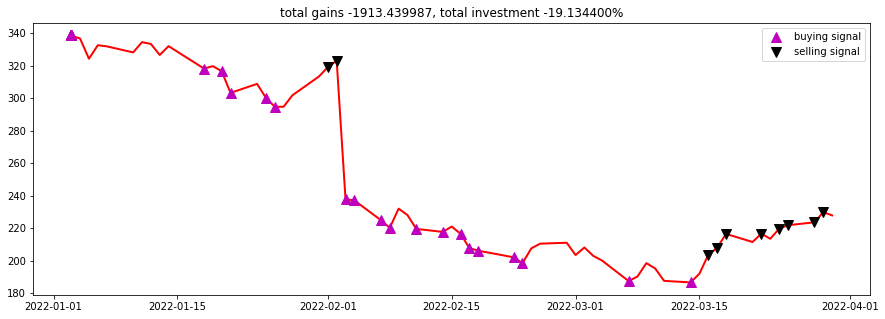

In [29]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()